In [1]:
import pandas as pd
import numpy as np
np.random.seed(1)
from scipy.optimize import linear_sum_assignment

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, '..')
import assignment
import leximin_assignment
import matrix_gen
import kde_utils

In [2]:
def custom_eff_assignment(cost_matrix, capacities):
    full_cost_matrix = np.repeat(cost_matrix, capacities, axis=1)
    row_ind, col_ind = linear_sum_assignment(full_cost_matrix)
    
    return (
        col_ind // (cost_matrix.shape[0] // cost_matrix.shape[1]),
        full_cost_matrix[row_ind, col_ind].sum()
    )


NS = [30, 40, 50, 60, 70, 80, 90, 100]
N_COLS = 5
N_EXPERIMENTS = 500

distrs = [
    np.random.uniform,
    np.random.beta
]
params = [(0, 1), (0.5, 0.5)]
labels = ['U[0, 1]', 'Beta(0.5, 0.5)']

# Growth of upper bounds

In [3]:
r_u = [[[] for _ in NS] for __ in distrs]
r_n = [[[] for _ in NS] for __ in distrs]

for i in range(len(labels)):
    for n_i, n in enumerate(NS):
        capacities = np.ones(N_COLS, dtype=int) * (n // N_COLS)
        matrix_generator = matrix_gen.MatrixGenerator(
            distrs[i], params[i], n, N_COLS
        )
        
        for _ in range(N_EXPERIMENTS):
            (_, sorted_matrix), (__, sorted_increase_matrix) = matrix_generator.get_increase_matrix_pair(
                round_=False
            )
            
            
            # L_u
            lex_u_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
                sorted_matrix, capacities
            )
            lex_u_assignments = lex_u_assigner.solve()
            
            b_u = lex_u_assigner.get_cost_increases(
                lex_u_assignments, increase_matrix=sorted_matrix
            ).max()
            l_u = sorted_matrix[:, -1].min()
            
            r_u[i][n_i].append(b_u / l_u)
            
            # L_n
            lex_n_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
                sorted_increase_matrix, capacities
            )
            lex_n_assignments = lex_n_assigner.solve()
            
            b_n = lex_n_assigner.get_cost_increases(
                lex_n_assignments, increase_matrix=sorted_increase_matrix
            ).max()
            # l_n = sorted_increase_matrix[:, -1].min()
            
            r_n[i][n_i].append(b_n / l_u)

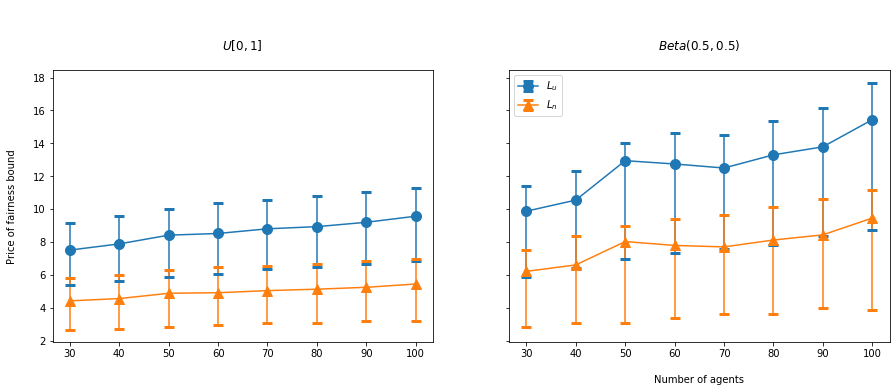

In [4]:
fig, ax = plt.subplots(1, len(labels), figsize=(15, 5), sharey=True)

for i in range(len(labels)):
    r_percnts = np.percentile(np.array(r_u[i]), [25, 75], axis=1)
    errors = r_percnts - np.array(r_u[i]).mean(axis=1)
    errors[0] *= -1
    errors = 1 + (N_COLS - 1) * errors
    ax[i].errorbar(
        NS, 1 + (N_COLS - 1) * np.array(r_u[i]).mean(axis=1),
        yerr=errors, label=r'$L_u$',
        capsize=5, capthick=3, marker='o', markersize=10
    )
    
    r_percnts = np.percentile(np.array(r_n[i]), [25, 75], axis=1)
    errors = r_percnts - np.array(r_n[i]).mean(axis=1)
    errors[0] *= -1
    errors = 1 + (N_COLS - 1) * errors
    ax[i].errorbar(
        NS, 1 + (N_COLS - 2) * np.array(r_n[i]).mean(axis=1),
        yerr=errors, label=r'$L_n$',
        capsize=5, capthick=3, marker='^', markersize=10
    )
    
    ax[i].set_title('\n\n' + '$' + labels[i] + r'$' + '\n')

ax[-1].legend()
ax[0].set_ylabel('Price of fairness bound\n')
ax[1].set_xlabel('\nNumber of agents');

# Growth of PoF$(L_u)$ and POF$(L_n)$

In [5]:
rerun = False

if rerun:
    eff_costs = [[[] for _ in NS] for __ in distrs]
    lu_costs = [[[] for _ in NS] for __ in distrs]
    ln_costs = [[[] for _ in NS] for __ in distrs]

    eff_sorted_costs = [[[] for _ in NS] for __ in distrs]
    lu_sorted_cost = [[[] for _ in NS] for __ in distrs]
    ln_sorted_cost = [[[] for _ in NS] for __ in distrs]

    for i in range(len(labels)):
        for n_i, n in enumerate(NS):
            print(labels[i], n)

            capacities = np.ones(N_COLS, dtype=int) * (n // N_COLS)
            matrix_generator = matrix_gen.MatrixGenerator(
                distrs[i], params[i], n, N_COLS
            )

            for _ in range(N_EXPERIMENTS):
                (
                    (matrix, sorted_matrix),
                    (increase_matrix, sorted_increase_matrix)
                ) = matrix_generator.get_increase_matrix_pair(round_=False)


                ### Original matrix
                # L_n
                lex_n_assigner = leximin_assignment.LeximinAssignmentHelperV3(
                    increase_matrix * 1000, capacities
                )
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    lex_n_assignments = lex_n_assigner.solve(verbose=False)
                if lex_n_assignments is False:
                    continue
                lex_n_cost = lex_n_assigner.get_cost(
                    lex_n_assignments, cost_matrix=matrix
                )

                # L_u
                lex_u_assigner = leximin_assignment.LeximinAssignmentHelperV3(
                    matrix * 1000, capacities
                )
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    lex_u_assignments = lex_u_assigner.solve(verbose=False)
                if lex_u_assignments is False:
                    continue
                lex_u_cost = lex_u_assigner.get_cost(
                    lex_u_assignments, cost_matrix=matrix
                )

                # Efficient
                eff_assignments, eff_cost = custom_eff_assignment(matrix, capacities)

                # pof_u[i][n_i].append(lex_u_cost / eff_cost)
                # pof_n[i][n_i].append(lex_n_cost / eff_cost)
                eff_cost[i][n_i].append(eff_cost)


                ### Increase (normalized) matrix
                # Efficient
                eff_assignments, eff_cost = custom_eff_assignment(sorted_matrix, capacities)

                # L_u
                lex_u_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
                    sorted_matrix, capacities
                )
                lex_u_assignments = lex_u_assigner.solve()
                lex_u_cost = lex_u_assigner.get_cost(
                    lex_u_assignments, cost_matrix=sorted_matrix
                )

                pof_sorted_u[i][n_i].append(lex_u_cost / eff_cost)

                # L_n
                lex_n_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
                    sorted_increase_matrix, capacities
                )
                lex_n_assignments = lex_n_assigner.solve()
                lex_n_cost = lex_n_assigner.get_cost(
                    lex_n_assignments, cost_matrix=sorted_matrix
                )

                pof_sorted_n[i][n_i].append(lex_n_cost / eff_cost)
else:
    labels.append('KDE')

In [6]:
if rerun:
    pof_lu_df = pd.DataFrame(columns=['PoF', 'N', 'Sorted rows'])

    for i in range(len(labels)):
        for n_i, n in enumerate(NS):
            pof_lu_df = pd.concat([
                pof_lu_df,
                pd.DataFrame({
                    'PoF': pof_u[i][n_i],
                    'N': n,
                    'Sorted rows': False
                }),
                pd.DataFrame({
                    'PoF': pof_sorted_u[i][n_i],
                    'N': n,
                    'Sorted rows': True
                })
            ])
else:
    pof_lu_df = pd.read_csv('saved_sim_results/pof_lu_df.csv')

In [7]:
if rerun:
    pof_ln_df = pd.DataFrame(columns=['PoF', 'N', 'Sorted rows'])

    for i in range(len(labels)):
        for n_i, n in enumerate(NS):
            pof_ln_df = pd.concat([
                pof_ln_df,
                pd.DataFrame({
                    'PoF': pof_n[i][n_i],
                    'N': n,
                    'Sorted rows': False
                }),
                pd.DataFrame({
                    'PoF': pof_sorted_n[i][n_i],
                    'N': n,
                    'Sorted rows': True
                })
            ])

    pof_ln_df.to_csv('pof_ln_df.csv', index=False)
else:
    pof_ln_df = pd.read_csv('saved_sim_results/pof_ln_df.csv')

/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


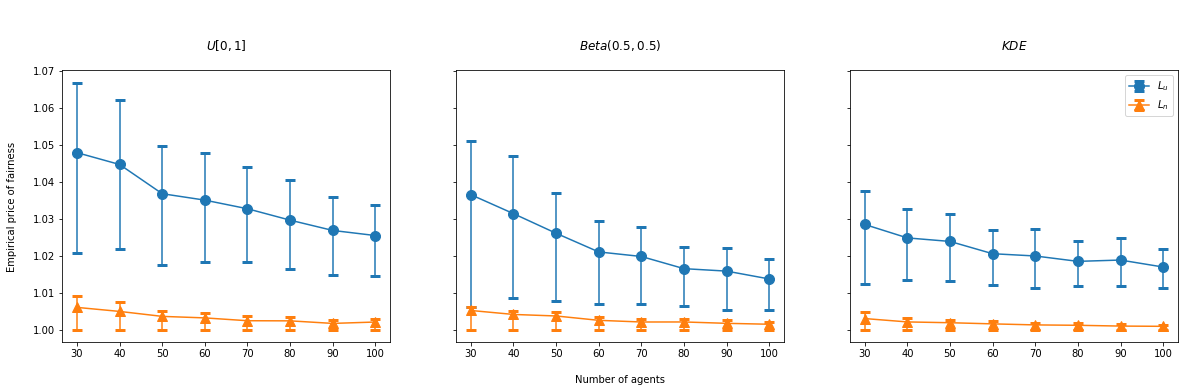

In [8]:
fig, ax = plt.subplots(1, len(labels), figsize=(20, 5), sharey=True)

for i in range(len(labels)):
    # PoF(L_u)
    grouped_pofs = pof_lu_df[~pof_lu_df['Sorted rows']][pof_lu_df['Distr'] == labels[i]].groupby('N')['PoF']
    percnts = grouped_pofs.quantile(q=[0.25, 0.75]).to_numpy().reshape(len(NS), 2).T
    means = grouped_pofs.mean().to_numpy()
    errors = percnts - means
    errors[0] *= -1
    ax[i].errorbar(
        NS, means,
        yerr=errors, label=r'$L_u$',
        capsize=5, capthick=3, marker='o', markersize=10
    )
    
    # PoF(L_n)
    grouped_pofs = pof_ln_df[~pof_ln_df['Sorted rows']][pof_ln_df['Distr'] == labels[i]].groupby('N')['PoF']
    percnts = grouped_pofs.quantile(q=[0.25, 0.75]).to_numpy().reshape(len(NS), 2).T
    means = grouped_pofs.mean().to_numpy()
    errors = percnts - means
    errors[0] *= -1
    ax[i].errorbar(
        NS, means,
        yerr=errors, label=r'$L_n$',
        capsize=5, capthick=3, marker='^', markersize=10
    )
    
    # ax[i].set_xlabel(r'$n$' + '\n\n' + '$' + labels[i] + r'$')
    # ax[i].set_xlabel('Number of agents' + '\n\n' + '$' + labels[i] + r'$')
    ax[i].set_title('\n\n' + '$' + labels[i] + r'$' + '\n')

ax[-1].legend()
ax[0].set_ylabel('Empirical price of fairness\n')
ax[1].set_xlabel('\nNumber of agents')
    
plt.show();

In [9]:
pof_lu_diff_df = pd.DataFrame(
    columns=['PoF diff', 'N', 'Distr']
)

for label in labels:
    for n in NS:
        filtered_df = pof_lu_df[
            (pof_lu_df['Distr'] == label)
            & (pof_lu_df['N'] == n)
        ]
        
        not_sorted_pof_lu = filtered_df[~ filtered_df['Sorted rows']]
        sorted_pof_lu = filtered_df[filtered_df['Sorted rows']]
        
        pof_lu_diff_df = pd.concat([
            pof_lu_diff_df,
            pd.DataFrame({
                'PoF diff': sorted_pof_lu['PoF'].to_numpy() - not_sorted_pof_lu['PoF'].to_numpy(),
                'N': n, 'Distr': label
            })
        ])

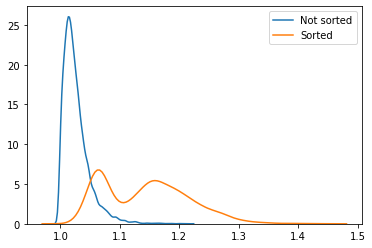

In [10]:
sns.kdeplot(pof_lu_df[~pof_lu_df['Sorted rows']]['PoF'], label='Not sorted')
sns.kdeplot(pof_lu_df[pof_lu_df['Sorted rows']]['PoF'], label='Sorted')
plt.legend();

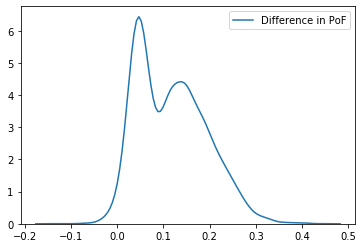

In [11]:
sns.kdeplot(pof_lu_diff_df['PoF diff'], label='Difference in PoF')
plt.legend();